# Observer masking: an alternative technique for removing days from RGO prior to ADF calibration

Andrés Muñoz-Jaramillo, Laure Lefevre, & Ilya Usoskin


## Objective and Conclusions

The goal of this notebook is to look in depth at two different methods for removing observations prior to calibration:

    1. Random Uniform.
    2. Mask based on the observer that will be calibrated.
    
Our argument is that observers rarely (if ever) skip observations randomly.  **The results presented here indicate that masked removal is clearly superior at producing ADF distributions that can be compared and calibrated.**

We also introduce the [Earth's Mover Metric (EMD)](https://link.springer.com/article/10.1023/A:1026543900054), an alternative metric to compare the distributions directly

## Things to Play With

* The observer that will be compared with RGO is specified in the cell below [**"Processing observer"**](#observer) in the variable _CalObs_
* Every time the cells below [**"Missing day masking as a possible better choice for day removal"**](#interval) are run, a new random section of RGO is used as reference.


## Other Parameters

* The duration of the calibration "month" is specified in the cell below [**"Recasting observations into equal intervals of specified duration"**](#duration) in the variable _MoLngt_



# Modules, colors, and functions

In [1]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)

# Histogram and scatter plot
def plotHistSqrtSSN(ax, calRefT, calObsT, maxN):

    # Number of bins to use
    Nbins = np.sqrt(calRefT.shape[0])/5
    Nbins = 15
    
    
    calRefT = np.sqrt(calRefT+1)
    calObsT = np.sqrt(calObsT+1)
    
    #Edges and Centers
    edges = np.arange(1,np.ceil(maxN), (np.ceil(maxN))/Nbins)
    centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2
    
    # Average group number 
    ax.hist2d(calObsT, calRefT, bins=edges, cmap=plt.cm.magma_r,cmin=1)
    
    # Calculating Quantities for plot
    hist, xedges, yedges = np.histogram2d(calObsT, calRefT, bins=edges)
    xx, yy = np.meshgrid(centers, centers)

    meanY = np.divide(np.sum(np.multiply(hist,xx),axis=1),np.sum(hist,axis=1))
    alphaY = np.sum(hist,axis=1)/np.max(np.sum(hist,axis=1))*0.95+0.05
    
    meanX = np.divide(np.sum(np.multiply(hist,yy),axis=0),np.sum(hist,axis=0))
    alphaX = np.sum(hist,axis=0)/np.max(np.sum(hist,axis=0))*0.95+0.05     
    
    mx, my = np.meshgrid(meanY, meanY)
    
    sDY = np.divide(np.sum(np.multiply(hist,np.power(xx-my,2)),axis=1),np.sum(hist,axis=1))
    
    # Calculating quantities for assessment
    y = meanY
    x = centers
    
    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)]
    

    
    # R squared
    yMean = np.mean(y)    
    SStot = np.sum(np.power(y-yMean,2)) 
    SSreg = np.sum(np.power(y-x,2))
    rSq   = (1 - SSreg/SStot)*sp.stats.pearsonr(x,y)[0]
    
    # Mean Residual
    mRes = np.mean(y-x)
    
    print(meanY)
    print(sDY)
    
    # Plot centers in Y
    for i in range(0, meanY.shape[0]):
        ax.errorbar(centers[i], meanY[i], sDY[i], color='k', zorder=11, alpha=alphaY[i])
        ax.scatter(centers[i], meanY[i], color='w', edgecolor='k', s=100, linewidths = 3, zorder=11, alpha=alphaY[i])

        
    # for i in range(0, meanY.shape[0]):
    #     ax.scatter(meanX[i], centers[i],  color='b', edgecolor='b', s=50, linewidths = 3, zorder=11, alpha=alphaY[i])

    ax.plot(edges, edges, '--'
             , color = Clr[4], linewidth = 3)

    ax.text(0.5, 0.95,'$PCCR$=' + str(np.round(rSq,decimals=2)) + '  MR=' + str(np.round(mRes,decimals=2)), horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)


# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading RGO data

We use a reduced version of the RGO data as provided by the [Heliophysical Observatory, Debrecen
](http://fenyi.solarobs.csfk.mta.hu/en/databases/GPR/).  It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.   

In [2]:
#RGO_Dat = pd.read_csv('input_data/DRGO_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)
RGO_Dat = pd.read_csv('input_data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)

RGO_Dat['ORDINAL'] = RGO_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
RGO_Dat['FRACYEAR'] = RGO_Dat.apply(lambda x: x['YEAR'].astype(int)
                                            + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                            / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                               - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                  ,axis=1)

In [3]:
print(RGO_Dat)

       YEAR  MONTH  DAY  AREA1  AREA2   AREA3  AREA4  AREA5  AREA6  AREA7  \
0      1874      4   17  208.0    NaN     NaN    NaN    NaN    NaN    NaN   
1      1874      4   18  117.0    NaN     NaN    NaN    NaN    NaN    NaN   
2      1874      4   19    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
3      1874      4   20    0.0    0.0     0.0    0.0    0.0    0.0    0.0   
4      1874      4   21    0.0    0.0     0.0    0.0    0.0    0.0    0.0   
5      1874      4   22    0.0    0.0     0.0    0.0    0.0    0.0    0.0   
6      1874      4   23    0.0    0.0     0.0    0.0    0.0    0.0    0.0   
7      1874      4   24    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
8      1874      4   25    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
9      1874      4   26    NaN    NaN     NaN    NaN    NaN    NaN    NaN   
10     1874      4   27  150.0    NaN     NaN    NaN    NaN    NaN    NaN   
11     1874      4   28  285.0    NaN     NaN    NaN    NaN    NaN    NaN   

# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

In [4]:
GN_Dat = pd.read_csv('input_data/GNObservations_JV_V1.22.csv', quotechar = '"', encoding = 'ansi',header = 15)
GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)
#GN_Dat = GN_Dat.loc[:,['YEAR', 'MONTH', 'DAY', 'ORDINAL', 'STATION', 'GROUPS', 'FRACYEAR']]

## Reading observers

We create a variable to store each unique observer.  **NOTE THAT CURRENTLY EACH STATION HAS _ONLY_ ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD**.

We also remove the '0' station which indicates a day without observations.

The **_print_** statement on this cell can be use for reference as it shows the station number associated with each observer.

In [5]:
GN_Obs = pd.read_csv('input_data/GNObservers_JV_V1.22.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs[['STATION','OBSERVER']].to_string())

UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

     STATION                                   OBSERVER
0          1                        HARRIOT, T., OXFORD
1          2                         SCHEINER, C., ROME
2          3                          GALILEO, G., ROME
3          4                      GALILEO-SAKURAI, ROME
4          5                      COLOGNA, S., MONREALE
5          6                       JUNGIUS, J., HAMBURG
6          7                         CIGOLI, L.C., ROME
7          8                        COLONNA, F., NAPLES
8          9                          TARDE, J., FARLAT
9         10                    SAXONIUS, P., NUREMBERG
10        11                      MARIUS, S., NUREMBERG
11        12                      MALAPERT, C., BELGIUM
12        13                    RICCIOLI, J.B., BONONIA
13        14                  SMOGULECZ, D., INGOLSTADT
14        15                     SCHICKARD, W., TUBINGA
15        16               HORTENSIUS, M., LUGD. BATAV.
16        17                     MOGLING, D., DA

<a id='observer'></a>
# Processing observer

This cell picks the observer that will be calibrated to RGO.  Some interesting observers are:

* Spörer: 318 (lots of missing zeros)
* Leppig: 324 (short and consistent, but with lots of missing days)
* Wolfer: 338 (long and consistent)

Observations for the chosen observer are filled with NaNs for days without observations.


In [6]:
# Observer Station Number
CalObs = 412
NamObs = GN_Obs['OBSERVER'].values[GN_Obs['STATION'].values==CalObs]
NamObs = NamObs[0]
NamObs = NamObs[0:NamObs.find(',')]

#print(NamObs)

# Picking observations
ObsDat = GN_Dat[GN_Dat.STATION == CalObs].copy()

# Finding missing days
ObsInt  = np.arange(np.min(ObsDat['ORDINAL']), np.max(ObsDat['ORDINAL']+1))
MisDays =  np.logical_not(sp.in1d(ObsInt, ObsDat['ORDINAL'] ))

# Creating dataframe with NaNs for days without observations
year  = np.array(list(map(lambda x: datetime.date.fromordinal(x).year, ObsInt[MisDays])))
month = np.array(list(map(lambda x: datetime.date.fromordinal(x).month, ObsInt[MisDays])))
day   = np.array(list(map(lambda x: datetime.date.fromordinal(x).day, ObsInt[MisDays])))

station  = day*0+CalObs
observer = day*0+1
groups   = day*np.nan

fractyear = np.array(list(map(lambda year, month, day : year + (  datetime.date(year, month , day).toordinal()
                                            - datetime.date(year,1,1).toordinal() )
                                            / (  datetime.date(year+1,1,1).toordinal()
                                            - datetime.date(year,1,1).toordinal() ), year, month, day)))

NoObs = pd.DataFrame(np.column_stack((year, month, day, ObsInt[MisDays], station, observer, groups, fractyear)), columns = ObsDat.columns.values)

# Append dataframe with missing days
ObsDat = ObsDat.append(NoObs,ignore_index=True)

# Recast using original data types
origType = GN_Dat.dtypes.to_dict()
ObsDat = ObsDat.apply(lambda x: x.astype(origType[x.name]))

# Sorting according to date
ObsDat = ObsDat.sort_values('ORDINAL').reset_index(drop=True)


<a id='duration'></a>
## Recasting observations into equal intervals of specified duration


To simplify and speedup the analysis we segment the observational interval using "months" of arbitrary length. This allows us to reshape our time series into a matrix and perform matrix-vector operations that are much faster than for loops.

Only an integer amount of "months" is used in order to make the reshaping operation possible.

In [7]:
# Number of days per "month"
MoLngt = 30

# Minimum fraction of observed days for an interval to be considered useful
minObD = 0.33;


# OBSERVER
# Selecting the maximum integer amount of "months" out of the original data
grpsOb = ObsDat['GROUPS'].values
grpsOb = grpsOb[0:np.int(grpsOb.shape[0]/MoLngt)*MoLngt]

ordOb = ObsDat['ORDINAL'].values
ordOb = ordOb[0:np.int(ordOb.shape[0]/MoLngt)*MoLngt]

yrOb = ObsDat['FRACYEAR'].values
yrOb = yrOb[0:np.int(yrOb.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsOb = grpsOb.reshape((-1,MoLngt))
ordOb  = ordOb.reshape((-1,MoLngt))
yrOb   = yrOb.reshape((-1,MoLngt))


# RGO
# Turning RGO areas into number of groups
RGO_Grp = RGO_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
RGO_Grp['GROUPS'] = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],0) ,axis = 1)
RGO_Grp['GROUPS'] = RGO_Grp['GROUPS'].astype(float)
RGO_Grp.loc[np.isnan(RGO_Dat['AREA1']), 'GROUPS'] = np.nan

# Selecting the maximum integer amount of "months" out of the original data
grpsRGO = RGO_Grp['GROUPS'].values
grpsRGO = grpsRGO[0:np.int(grpsRGO.shape[0]/MoLngt)*MoLngt]

ordRGO = RGO_Grp['ORDINAL'].values
ordRGO = ordRGO[0:np.int(ordRGO.shape[0]/MoLngt)*MoLngt]

yrRGO = RGO_Grp['FRACYEAR'].values
yrRGO = yrRGO[0:np.int(yrRGO.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsRGO = grpsRGO.reshape((-1,MoLngt))
ordRGO  = ordRGO.reshape((-1,MoLngt))
yrRGO   = yrRGO.reshape((-1,MoLngt))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


## Calculating number of days with observations and number of days with groups 

In [8]:
# OBSERVER
# Number of days with observations
obsOb = np.sum(np.isfinite(grpsOb),axis=1)

# Number of days with groups
grpOb = np.sum(np.greater(grpsOb,0),axis=1)

# Average number of groups
AvGrpOb = np.nanmean(grpsOb,axis=1)
SdGrpOb = np.nanstd(grpsOb,axis=1)

# Interval edges for plotting
fyr1Ob = np.min(yrOb,axis=1)
fyr2Ob = np.max(yrOb,axis=1)


#RGO
# Number of days with observations
obsRGO = np.sum(np.isfinite(grpsRGO),axis=1)

# Number of days with groups
grpRGO = np.sum(np.greater(grpsRGO,0),axis=1)

# Average number of groups
AvGrpRGO = np.nanmean(grpsRGO,axis=1)
SdGrpRGO = np.nanstd(grpsRGO,axis=1)

# Interval edges for plotting
fyr1RGO = np.min(yrRGO,axis=1)
fyr2RGO = np.max(yrRGO,axis=1)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


## Plotting comparison the observer's and RGO's active vs. observed days per month

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater


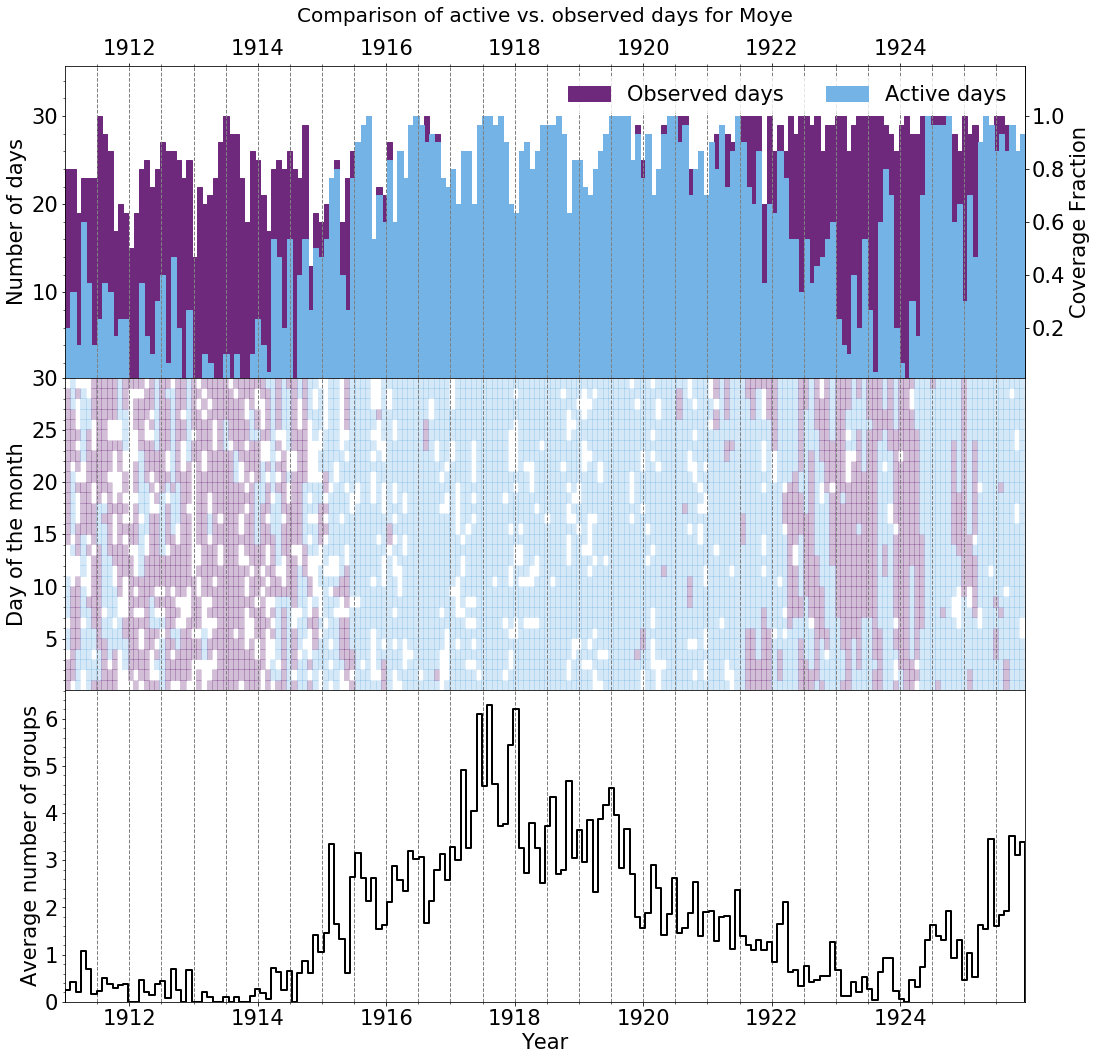

In [9]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltx = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltx = np.append(pltx,np.max(fyr2Ob))
pltx = np.append(pltx,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAv = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAv = np.insert(pltyAv,0,0)
pltyAv = np.append(pltyAv,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltx, pltyOb, color = Clr[2])
ax1.fill(pltx, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number 
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
#ax3.fill(pltx, pltyAv+pltySd, color = '0.8')
#ax3.fill(pltx, pltyAv-pltySd, color = 'w')
ax3.plot(pltx, pltyAv, color = Clr[0], linewidth = 2)

# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0);

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater


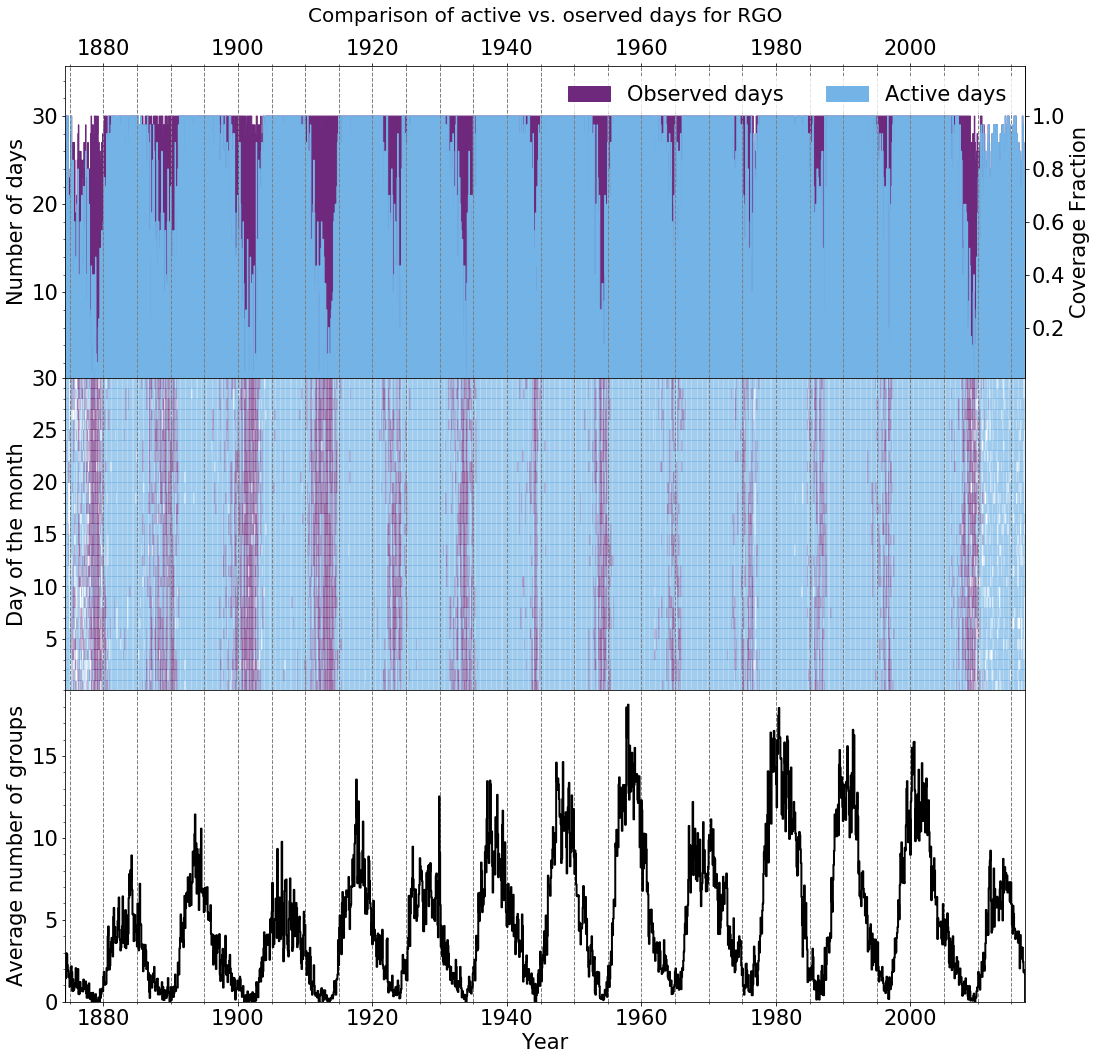

In [10]:
# RGO plot
# Stack horizontal left ends to level the step-wise plot
pltx = np.stack((fyr1RGO,fyr1RGO)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltx = np.append(pltx,np.max(fyr2RGO))
pltx = np.append(pltx,np.max(fyr2RGO))

# Stack duplicate array to level the step-wise plot 
pltyRGO = np.stack((obsRGO,obsRGO)).reshape((1,-1),order='F')
pltyGr = np.stack((grpRGO,grpRGO)).reshape((1,-1),order='F')
pltyAv = np.stack((AvGrpRGO,AvGrpRGO)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpRGO,SdGrpRGO)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyRGO = np.insert(pltyRGO,0,0)
pltyRGO = np.append(pltyRGO,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAv = np.insert(pltyAv,0,0)
pltyAv = np.append(pltyAv,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with RGOservations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with RGOservations
ax1.fill(pltx, pltyRGO, color = Clr[2])
ax1.fill(pltx, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without RGOservations)

# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. oserved days for RGO', horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1RGO), right = np.max(fyr2RGO))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/RGOservation/missing mesh
AcRGOMesh = np.isfinite(grpsRGO).astype(int)+np.greater(grpsRGO,0).astype(int)
xMesh = np.insert(fyr2RGO,0,fyr1RGO[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcRGOMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number 
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
#ax3.fill(pltx, pltyAv+pltySd, color = '0.8')
#ax3.fill(pltx, pltyAv-pltySd, color = 'w')
ax3.plot(pltx, pltyAv, color = Clr[0], linewidth = 2)

# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1RGO), right = np.max(fyr2RGO))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0);

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.


# Diagnostic of the relationship between active days and observed days

In general, observers have a duty cycle that is smaller than 100%.  To make RGO ADF ratios comparable, a fraction of the observed days is removed with uniform probability.   However, one potential issue with an ADF reconstruction is the systematic tendency of observers to under-report days without sunspots.  This can make the observer seem like it has a higher sensitivity.  Here we explore the correlation between active days, observed days, and average group number. Using different ways of removing days of RGO.  The idea is to come up with a diagnostic of the "quality" of an observer and a methodology to make RGO more compatible prior to calibration. 


## Change in RGO fractions after removal of a uniform fraction of days

In [11]:
# Fraction of Observed days for Reference Observer
ObsFrac = np.mean(obsOb/MoLngt)

# Generating random mask
msk = np.random.rand(grpsRGO.shape[0],grpsRGO.shape[1])>=ObsFrac
MgrpsRGO = deepcopy(grpsRGO)
MgrpsRGO[msk] = np.nan

# Number of days with observations
MobsRGO = np.sum(np.isfinite(MgrpsRGO),axis=1)

# Number of days with groups
MgrpRGO = np.sum(np.greater(MgrpsRGO,0),axis=1)

# Average number of groups
MAvGrpRGO = np.nanmean(MgrpsRGO,axis=1)
MSdGrpRGO = np.nanstd(MgrpsRGO,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater


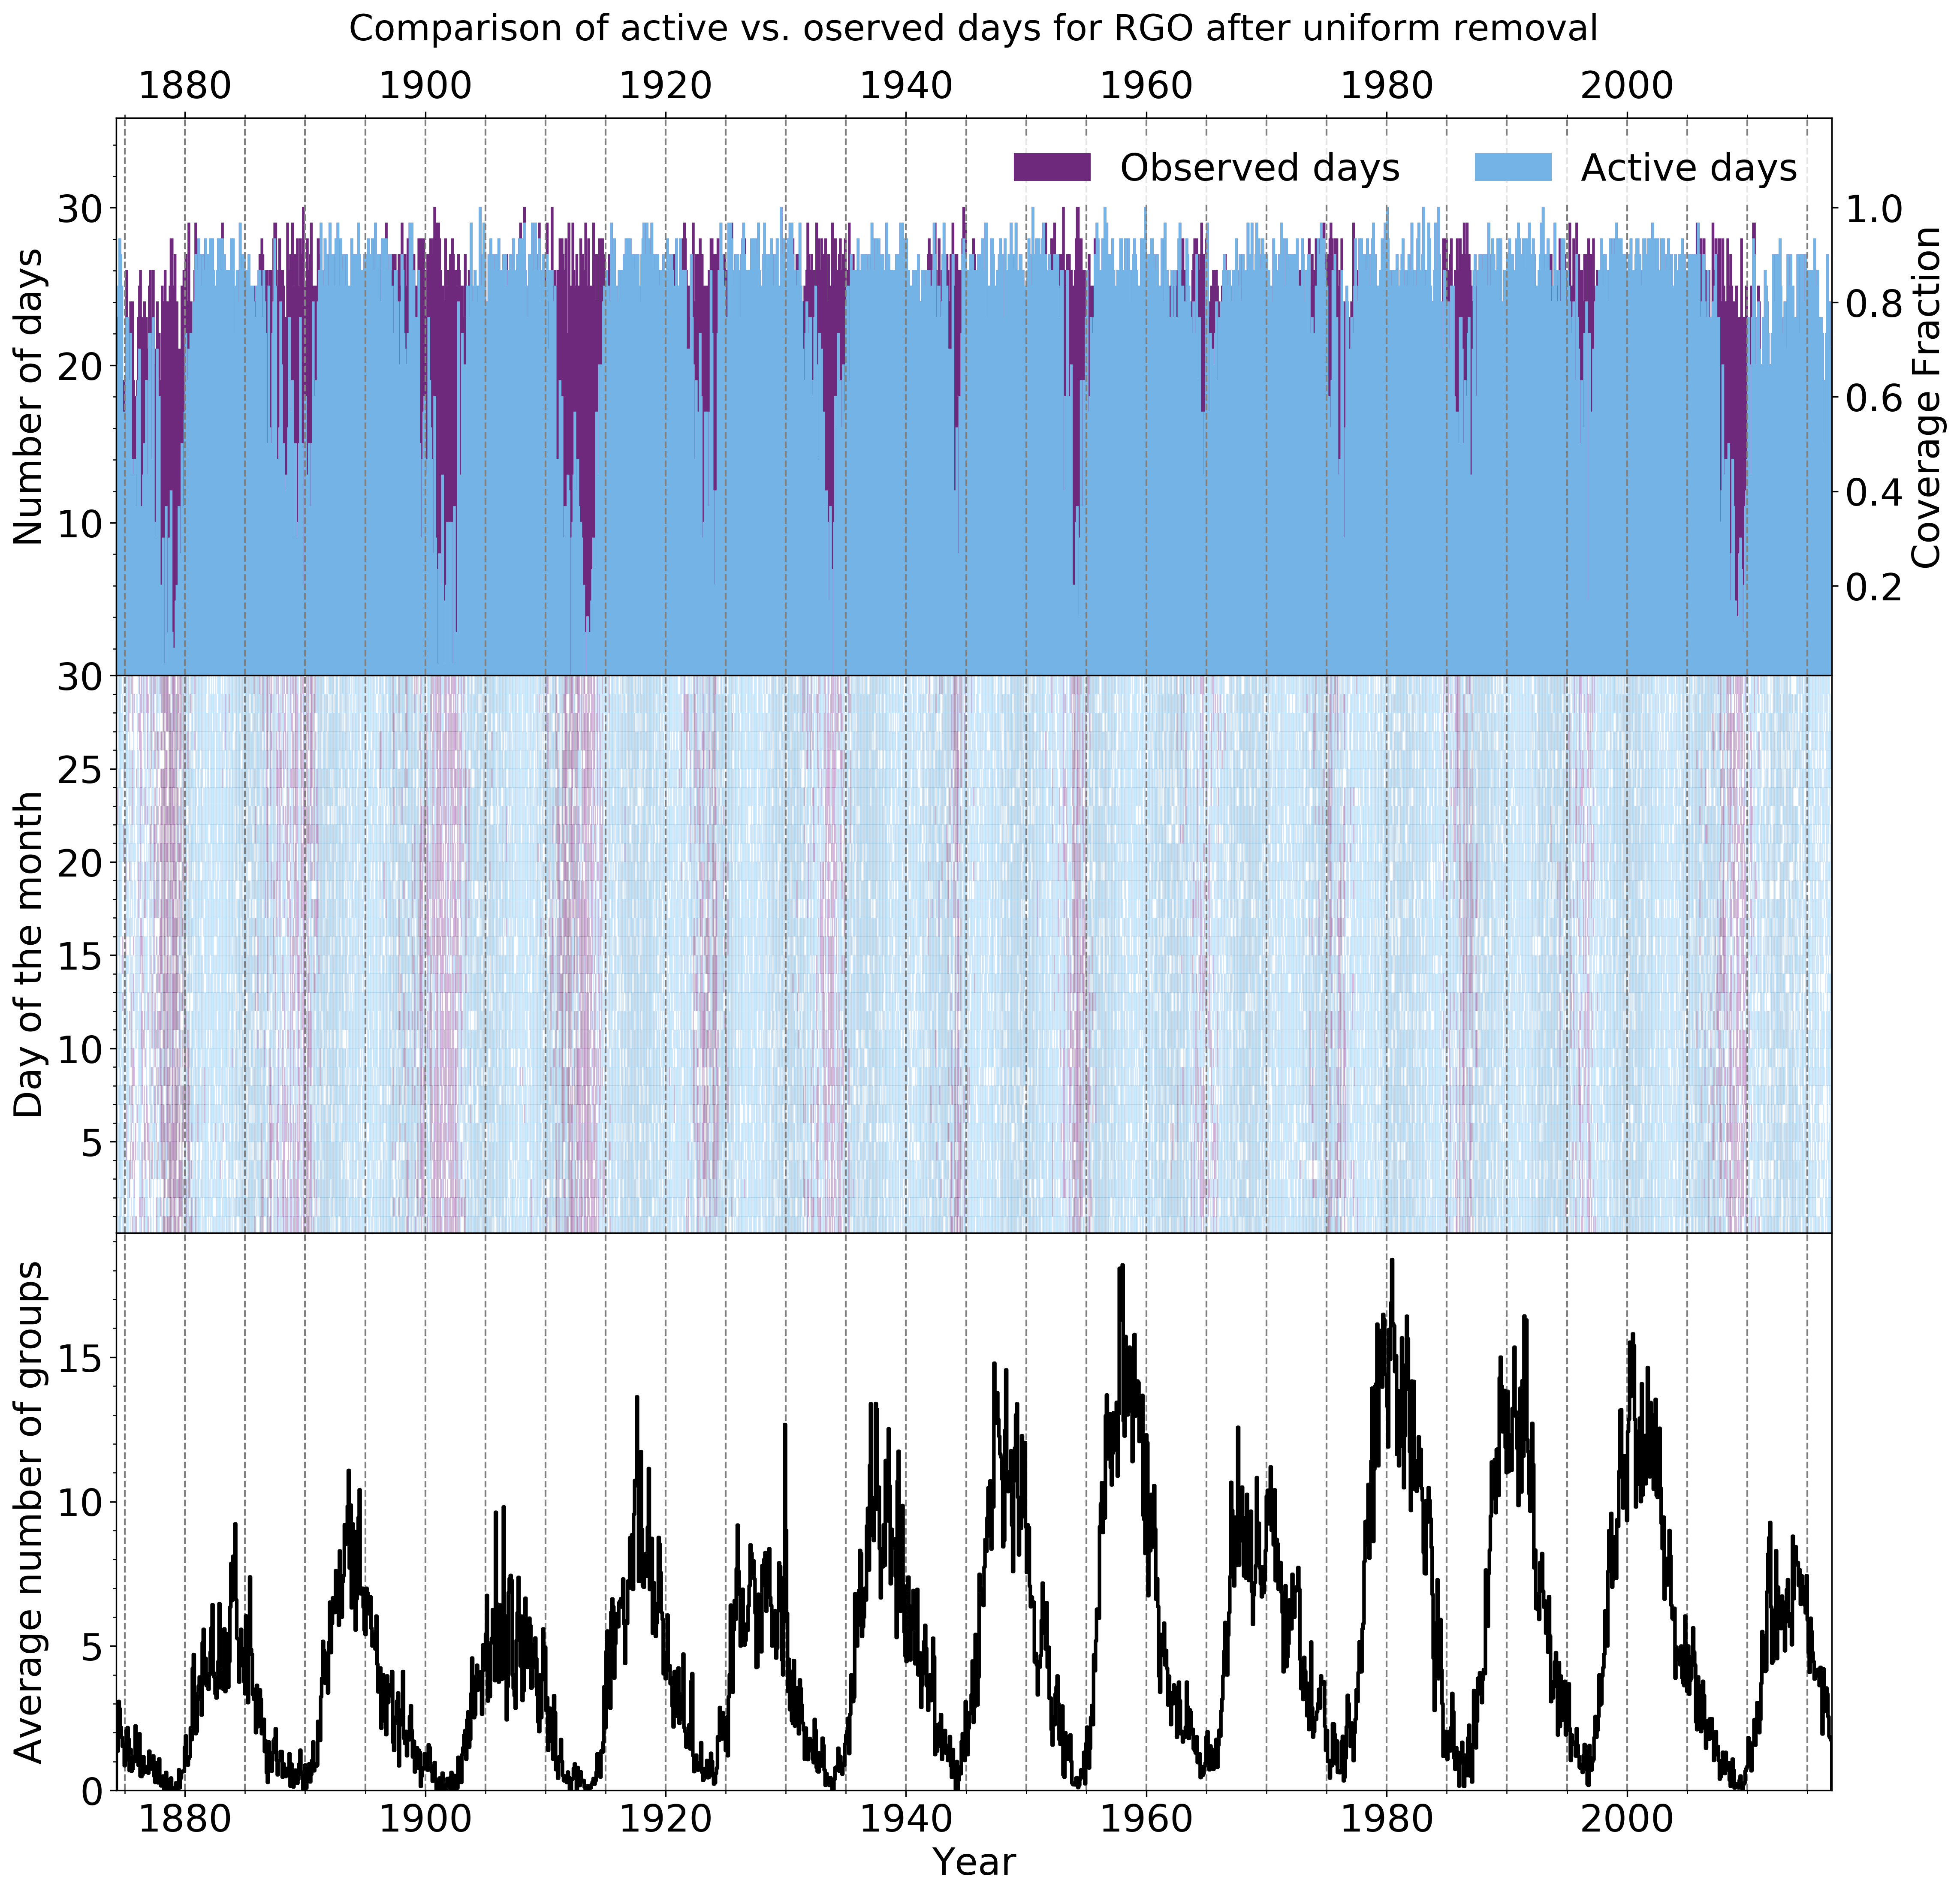

In [12]:
#Plot masked RGO
# Stack horizontal left ends to level the step-wise plot
pltx = np.stack((fyr1RGO,fyr1RGO)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltx = np.append(pltx,np.max(fyr2RGO))
pltx = np.append(pltx,np.max(fyr2RGO))

# Stack duplicate array to level the step-wise plot 
pltyRGO = np.stack((MobsRGO,MobsRGO)).reshape((1,-1),order='F')
pltyGr = np.stack((MgrpRGO,MgrpRGO)).reshape((1,-1),order='F')
pltyAv = np.stack((MAvGrpRGO,MAvGrpRGO)).reshape((1,-1),order='F')
pltySd = np.stack((MSdGrpRGO,MSdGrpRGO)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyRGO = np.insert(pltyRGO,0,0)
pltyRGO = np.append(pltyRGO,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAv = np.insert(pltyAv,0,0)
pltyAv = np.append(pltyAv,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with RGOservations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with RGOservations
ax1.fill(pltx, pltyRGO, color = Clr[2])
ax1.fill(pltx, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without RGOservations)

# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. oserved days for RGO after uniform removal', horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1RGO), right = np.max(fyr2RGO))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/RGOservation/missing mesh
AcRGOMesh = np.isfinite(MgrpsRGO).astype(int)+np.greater(MgrpsRGO,0).astype(int)
xMesh = np.insert(fyr2RGO,0,fyr1RGO[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcRGOMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number 
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
#ax3.fill(pltx, pltyAv+pltySd, color = '0.8')
#ax3.fill(pltx, pltyAv-pltySd, color = 'w')
ax3.plot(pltx, pltyAv, color = Clr[0], linewidth = 2)

# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1RGO), right = np.max(fyr2RGO))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0);

**FIGURE:** _Top:_ Number of active (non-zero; blue) and observed (purple) days during each month.

_Middle:_ Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue).  The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

_Bottom:_ Average number of groups each month.


## Distributions of active day fractions and observed day fractions for given observer

The active day fraction method identifies the detection threshold of a given observer by identifying the closest cumulative distribution function observed by RGO after applying varying thresholds.  The concern is that focusing on the active day fraction only, without looking at the observed day fraction, may yield erroneous thresholds.  The distributions for the given observer look like this:

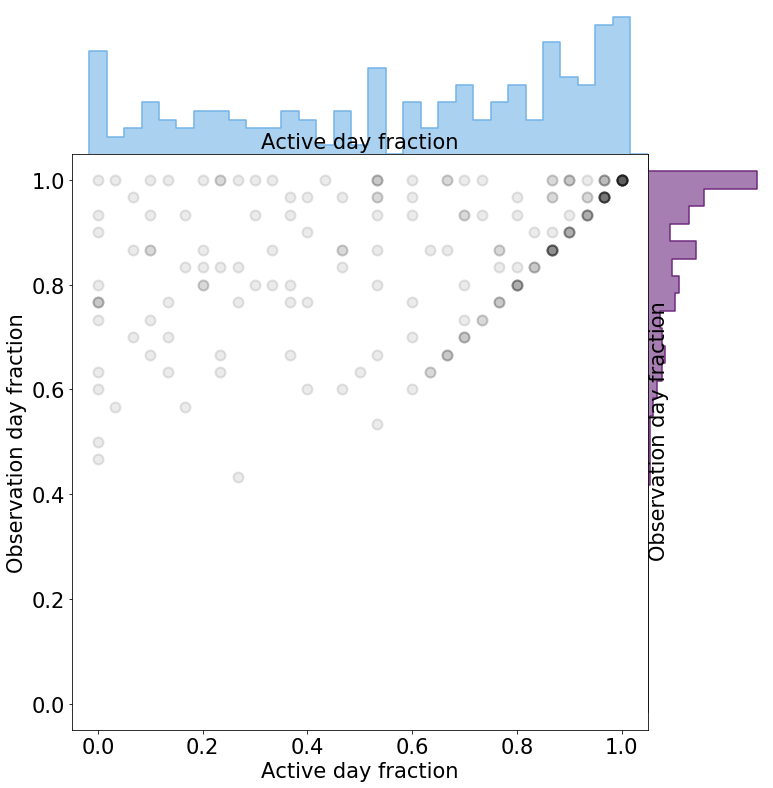

In [13]:
# Distribution Plots for Observer

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Top Distribution
axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
ADFObs, bins, patches = axd.hist(grpOb[obsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[4], alpha=.6, density = True);
(xAD, yAD) = histOutline(grpOb[obsOb/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
axd.plot(xAD, yAD, color=Clr[4])

# Axes properties
axd.set_xlim(left = -0.05, right = 1.05);
axd.set_axis_off()


# Right Distribution
ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
ax2.hist(obsOb[obsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color=Clr[2], alpha=.6, orientation = 'horizontal', density = True);
(xOD, yOD) = histOutline(obsOb[obsOb/MoLngt>=minObD]/MoLngt, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
ax2.plot(yOD, xOD, color=Clr[2])

# Axes properties
ax2.set_ylim(bottom = -0.05, top = 1.05);
ax2.set_axis_off()

# Scatter Plot
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
ax1.scatter(grpOb/MoLngt, obsOb/MoLngt, color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)
#ax1.plot(np.array([-0.05,1.05]), np.array([1,1])*minObD, 'k--')

# Axes properties
ax1.set_ylabel('Observation day fraction')
ax1.text(1.02, 0.52,'Observation day fraction', horizontalalignment='center', transform = ax1.transAxes, 
         rotation = 'vertical', verticalalignment = 'center')
ax1.set_xlabel('Active day fraction')
ax1.text(0.5, 1.01,'Active day fraction', horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = -0.05, right = 1.05)
ax1.set_ylim(bottom = -0.05, top = 1.05);


**FIGURE:** Scatter plot connecting the active day and observed day fraction, as well as the marginal distributions for each of the quantities.   Colored areas indicate the distributions for the given observer and will be shown later for comparison with RGO.


# The Earth Mover's Distance (Wasserstein metric)

As part of our effort to make ADF more robust we introduce the Earth Mover's distance (EMD) to quantify how different are Observer's and RGO's distribution of ADFs.

[See description paper here](http://ai.stanford.edu/~rubner/papers/rubnerIjcv00.pdf)

The basic idea of the EMD is to depict distributions as piles of dirt and quantify the amount of "work" that an earth mover would need to do in order to transform one distribution into the other.   Here we use the pyemd package:

[https://github.com/wmayner/pyemd](https://github.com/wmayner/pyemd)


## Calculating RGO ADF for different thresholds after removal of a uniform fraction of days 

In [14]:
from pyemd import emd

# Number of thresholds 
thN = 9
MgrpRGOT = np.repeat(np.matrix(MgrpRGO),thN+1, axis = 0)

# Calculation of distance matrix to be used in the Earth Movers Metric
x = np.arange(0,ADFObs.shape[0])
y = np.arange(0,ADFObs.shape[0])
xx, yy = np.meshgrid(x, y)
Dis = np.power(xx-yy,2)

# Looping through different thresholds and calculating active day fraction
EMD = []
for i in range(1,thN+1):
    
    TgrpsRGO = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],i*10) ,axis = 1).astype(float)
    TgrpsRGO[np.isnan(RGO_Dat['AREA1'])] = np.nan

    # Selecting the maximum integer amount of "months" out of the original data
    TgrpsRGO = TgrpsRGO[0:np.int(TgrpsRGO.shape[0]/MoLngt)*MoLngt]
    # Reshaping
    TgrpsRGO = TgrpsRGO.reshape((-1,MoLngt))
    # Removing days using mask
    TgrpsRGO[msk] = np.nan
    
    # Number of days with groups
    MgrpRGOT[i,:] = np.sum(np.greater(TgrpsRGO,0),axis=1)
    
    #Calculating Earth Mover's Distance
    ADFRGO, bins = np.histogram(np.squeeze(np.asarray(MgrpRGOT[i,:]))/30, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
    EMD.append(emd(ADFRGO.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


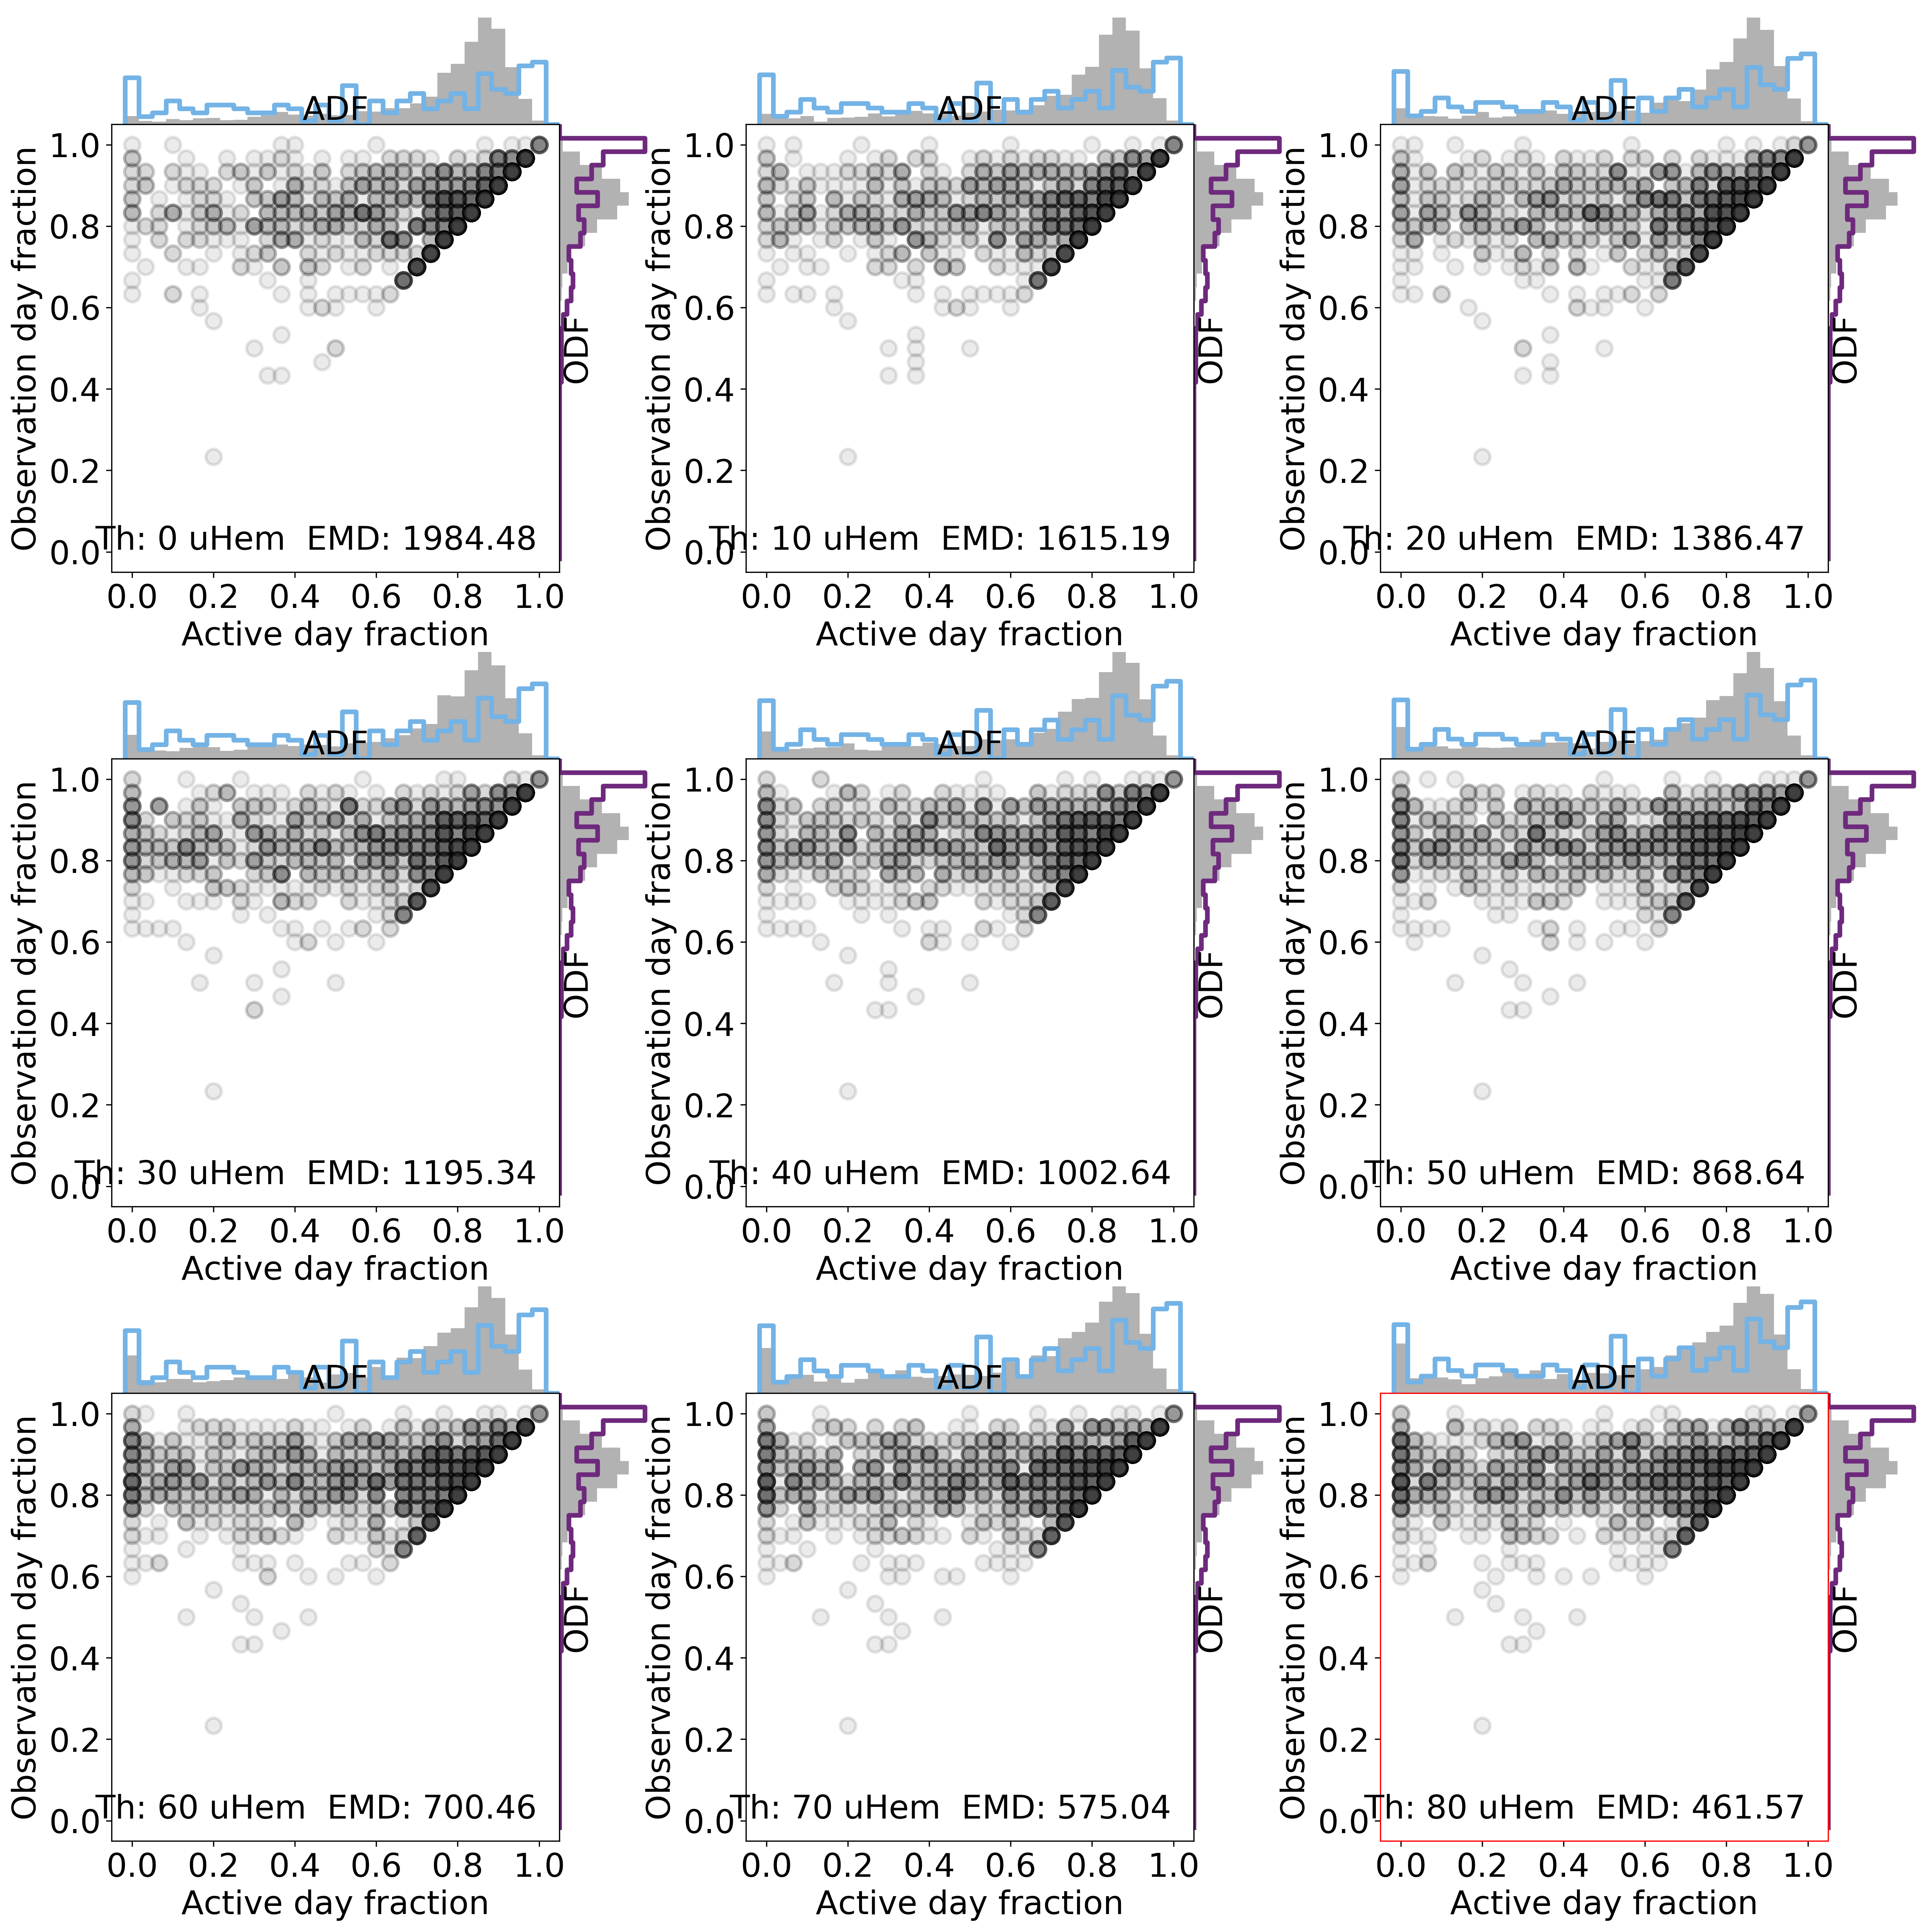

In [15]:
plt.rc('font', **font)

# Distribution Plots for RGO
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 200 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


for i in range(0, 3):
    for j in range(0,3):
        n = (3*(2-j)+i)

        # Top Distribution
        ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) , ppadv + j*(pxy/fszv+ppadv2) + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
        ax1.hist(np.squeeze(np.asarray(MgrpRGOT[n,:]))/30, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color='0.5', alpha=.6, density = True);
        ax1.plot(xAD, yAD, color=Clr[4], linewidth=3)
      
        # Axes properties
        ax1.set_xlim(left = -0.05, right = 1.05);
        ax1.set_axis_off()


        # Right Distribution
        ax2 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) + pxx/fszh*frc, ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc*(1-frc), pxy/fszv*frc])
        ax2.hist(MobsRGO/30, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color='0.5', alpha=.6, orientation = 'horizontal', density = True);
        (xOD, yOD) = histOutline(obsOb/30, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        ax2.plot(yOD, xOD, color=Clr[2], linewidth=3)

        # Axes properties
        ax2.set_ylim(bottom = -0.05, top = 1.05);
        ax2.set_axis_off()

        # Scatter Plot
        ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
        ax1.scatter(np.squeeze(np.asarray(MgrpRGOT[n,:]))/30, MobsRGO/30, color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)

        # Axes properties
        ax1.set_ylabel('Observation day fraction')
        ax1.text(1.04, 0.5,'ODF', horizontalalignment='center', transform = ax1.transAxes, 
                 rotation = 'vertical', verticalalignment = 'center')
        ax1.set_xlabel('Active day fraction')
        ax1.text(0.5, 1.01,'ADF', horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.95, 0.05,  'Th: ' + str(n*10) + ' uHem  EMD: ' + str(np.round_(EMD[n], decimals = 2)), horizontalalignment='right', transform = ax1.transAxes)
        ax1.set_xlim(left = -0.05, right = 1.05)
        ax1.set_ylim(bottom = -0.05, top = 1.05);
        
        if EMD[n]==np.min(EMD):
            ax1.spines['bottom'].set_color('r')
            ax1.spines['top'].set_color('r') 
            ax1.spines['right'].set_color('r')
            ax1.spines['left'].set_color('r')




**FIGURE:** Each panel shows the scatter plot connecting the active day and observed day fraction, as well as the marginal distributions for each of the quantities.   Gray shaded areas correspond to the distributions arising from RGO after uniform removal of days.  Colored lines indicate the distributions for the given observer.  Each panel denotes the threshold used to obtain the distributions, as well as the Earth Mover's distance (EMD).  The panel outlined in red has the smallest EMD between RGO and the observer.


<a id='interval'></a>
## Missing day masking as a possible better choice for day removal

As can be seen in the previous figures, the random removal of RGO days using a uniform distributions yields active and observed day distributions that differ visibly from observed ones.  The alternative approach that we would like to propose is to limit the calibration to RGO periods of equal length as the observer that we want to calibrate and imprint an observational mask on RGO.

**The cells below pick a random interval during the RGO era.  Running them again will result in different distributions and a different period.  Later the idea is to include the period in the optimization.**

In [16]:
# Picking a random RGO interval of the same duration as the given observer's observations
Idx1 = (np.random.rand(1)*(RGO_Dat.shape[0]-ObsDat.shape[0])).astype(int)
Idx2 = Idx1 + ObsDat.shape[0]

# Cutting that section from the RGO set
CutRGO_Grp = RGO_Grp.iloc[Idx1[0]:Idx2[0], :].copy()

# Selecting the maximum integer amount of "months" out of the original data
CgrpsRGO = CutRGO_Grp['GROUPS'].values
CgrpsRGO = CgrpsRGO[0:np.int(CgrpsRGO.shape[0]/MoLngt)*MoLngt]

CordRGO = CutRGO_Grp['ORDINAL'].values
CordRGO = CordRGO[0:np.int(CordRGO.shape[0]/MoLngt)*MoLngt]

CyrRGO = CutRGO_Grp['FRACYEAR'].values
CyrRGO = CyrRGO[0:np.int(CyrRGO.shape[0]/MoLngt)*MoLngt]

# Reshaping
CgrpsRGO = CgrpsRGO.reshape((-1,MoLngt))
CordRGO  = CordRGO.reshape((-1,MoLngt))
CyrRGO   = CyrRGO.reshape((-1,MoLngt))

# Imprinting missing days mask
CgrpsRGO[np.isnan(grpsOb)] = np.nan

# Number of days with observations
CobsRGO = np.sum(np.isfinite(CgrpsRGO),axis=1)

# Number of days with groups
CgrpRGO = np.sum(np.greater(CgrpsRGO,0),axis=1)

# Average number of groups
CAvGrpRGO = np.nanmean(CgrpsRGO,axis=1)
CSdGrpRGO = np.nanstd(CgrpsRGO,axis=1)

# Interval edges for plotting
Cfyr1RGO = np.min(CyrRGO,axis=1)
Cfyr2RGO = np.max(CyrRGO,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater


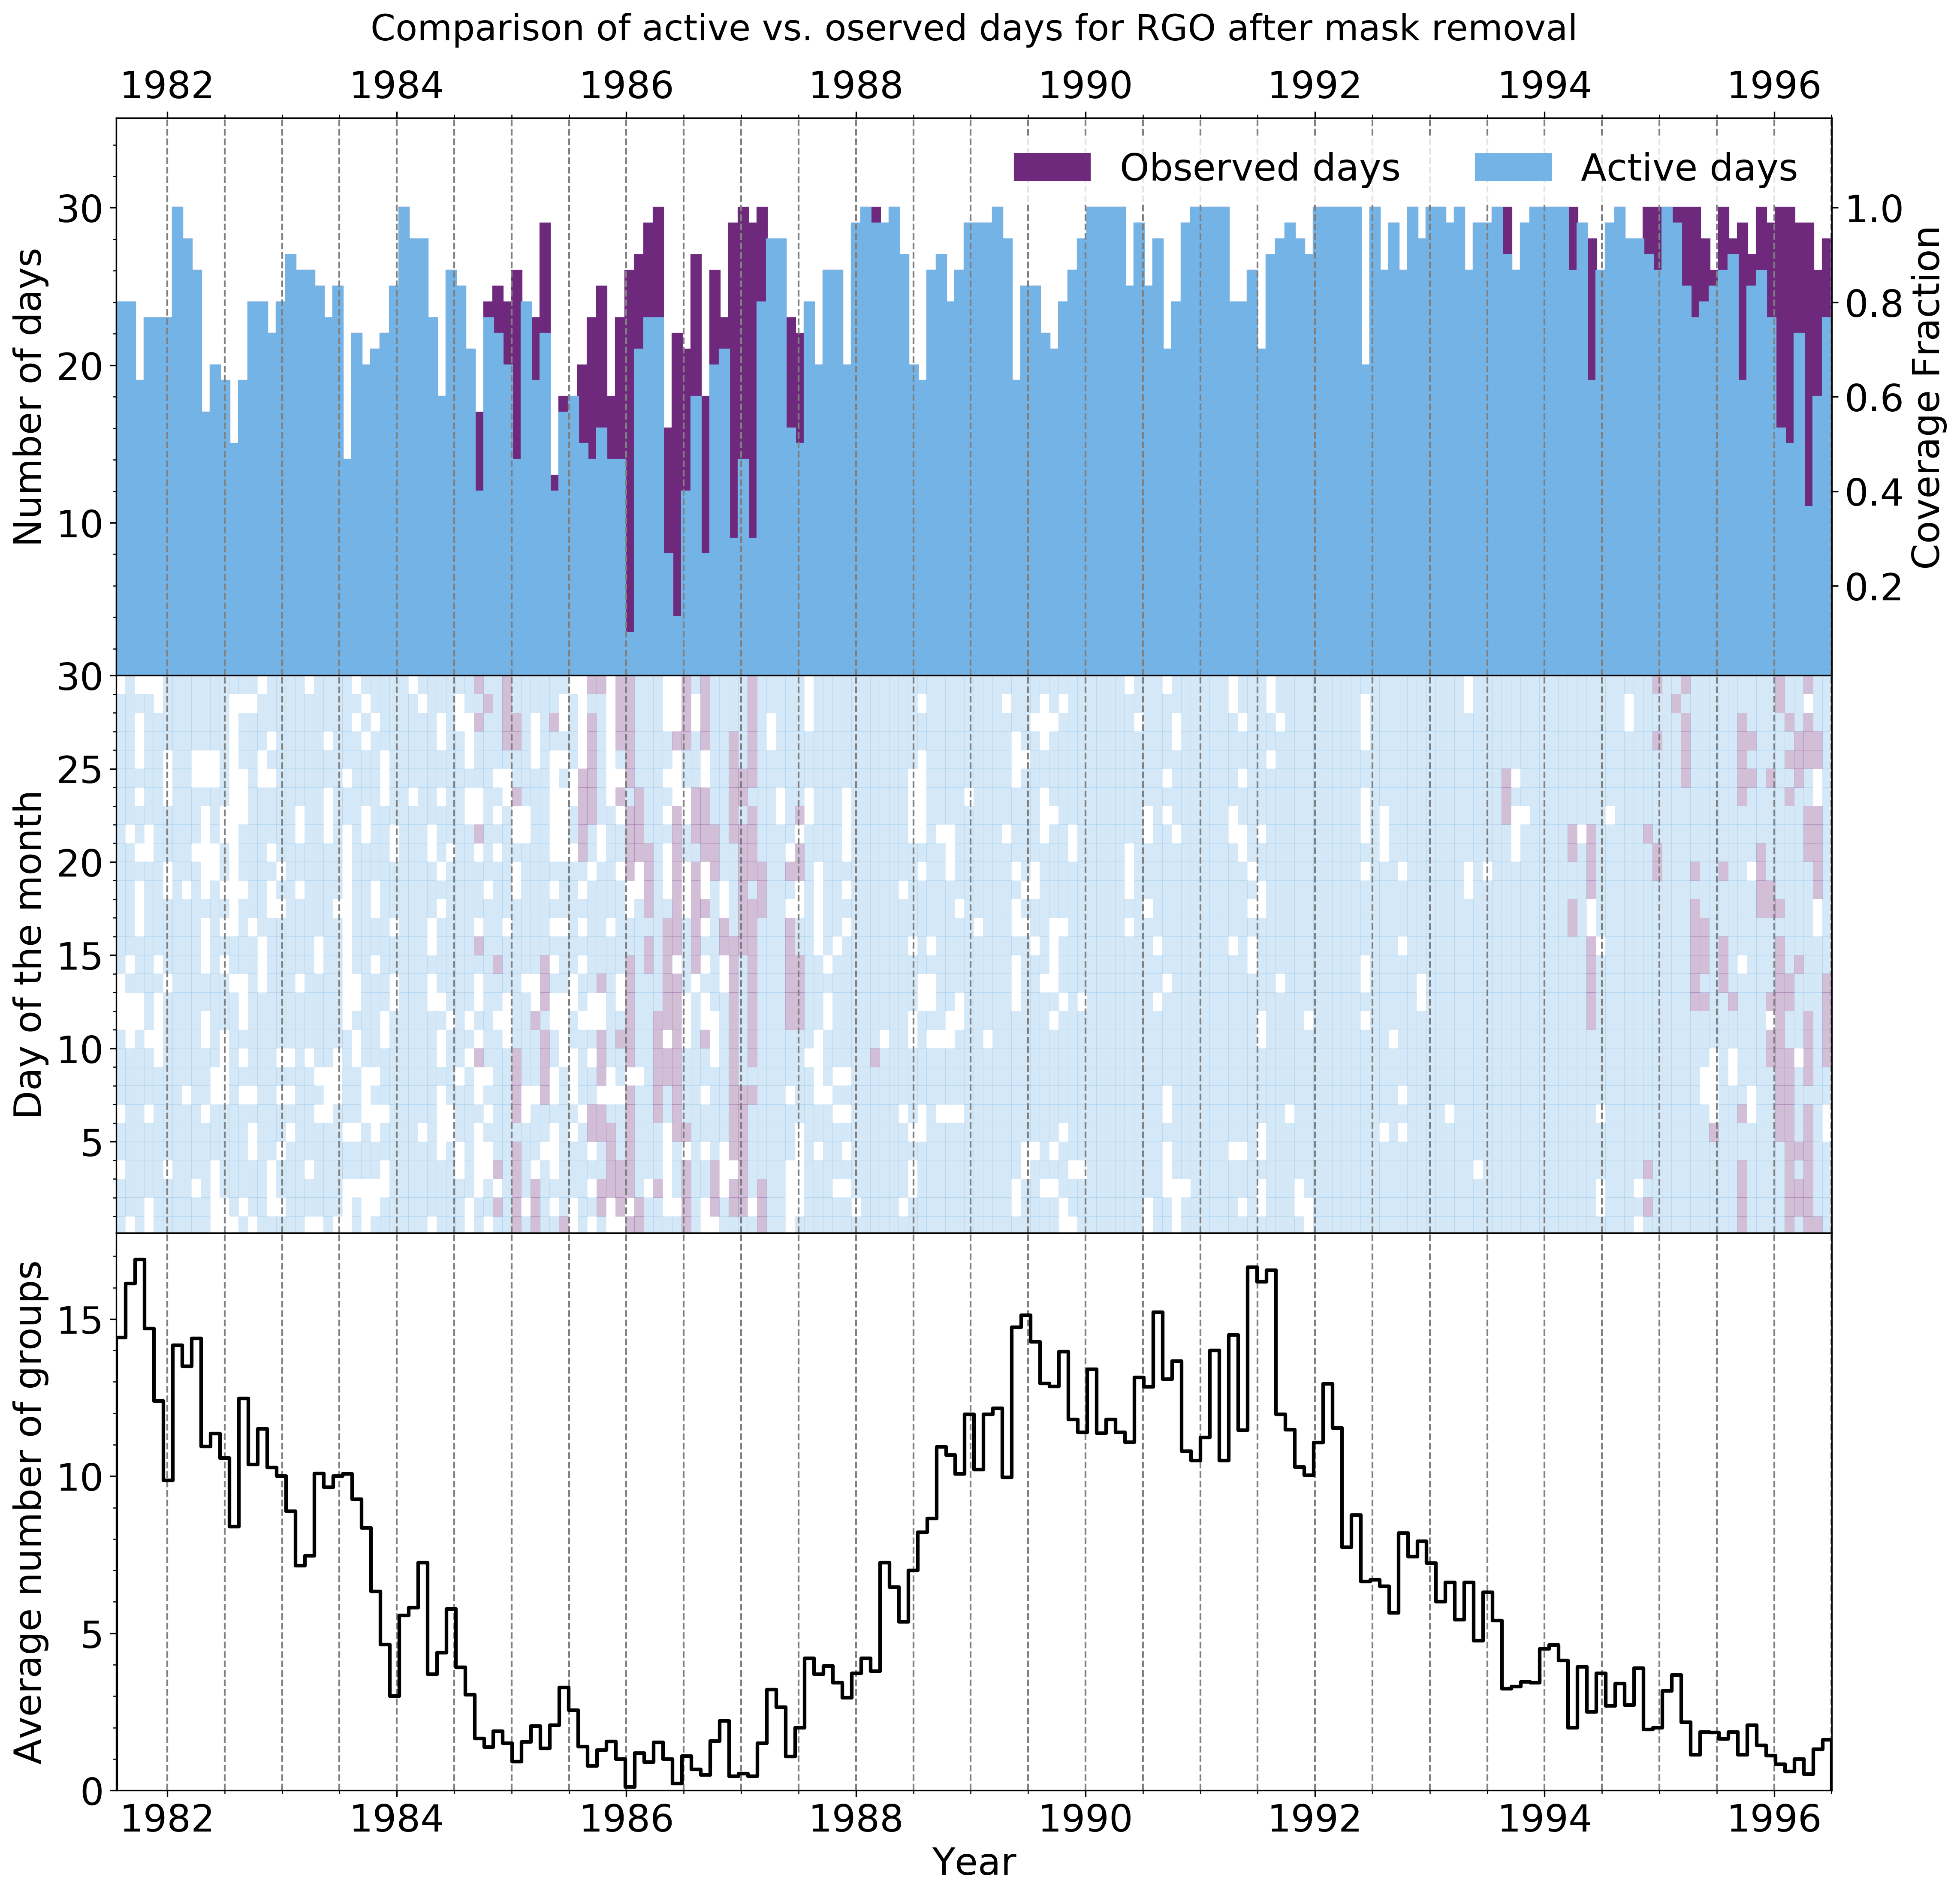

In [17]:
#Plot masked RGO
# Stack horizontal left ends to level the step-wise plot
pltx = np.stack((Cfyr1RGO,Cfyr1RGO)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltx = np.append(pltx,np.max(Cfyr2RGO))
pltx = np.append(pltx,np.max(Cfyr2RGO))

# Stack duplicate array to level the step-wise plot 
pltyRGO = np.stack((CobsRGO,CobsRGO)).reshape((1,-1),order='F')
pltyGr = np.stack((CgrpRGO,CgrpRGO)).reshape((1,-1),order='F')
pltyAv = np.stack((CAvGrpRGO,CAvGrpRGO)).reshape((1,-1),order='F')
pltySd = np.stack((CSdGrpRGO,CSdGrpRGO)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyRGO = np.insert(pltyRGO,0,0)
pltyRGO = np.append(pltyRGO,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAv = np.insert(pltyAv,0,0)
pltyAv = np.append(pltyAv,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with RGOservations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with RGOservations
ax1.fill(pltx, pltyRGO, color = Clr[2])
ax1.fill(pltx, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without RGOservations)

# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. oserved days for RGO after mask removal', horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(Cfyr1RGO), right = np.max(Cfyr2RGO))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/RGOservation/missing mesh
AcRGOMesh = np.isfinite(CgrpsRGO).astype(int)+np.greater(CgrpsRGO,0).astype(int)
xMesh = np.insert(Cfyr2RGO,0,Cfyr1RGO[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcRGOMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number 
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
#ax3.fill(pltx, pltyAv+pltySd, color = '0.8')
#ax3.fill(pltx, pltyAv-pltySd, color = 'w')
ax3.plot(pltx, pltyAv, color = Clr[0], linewidth = 2)

# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(Cfyr1RGO), right = np.max(Cfyr2RGO))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater


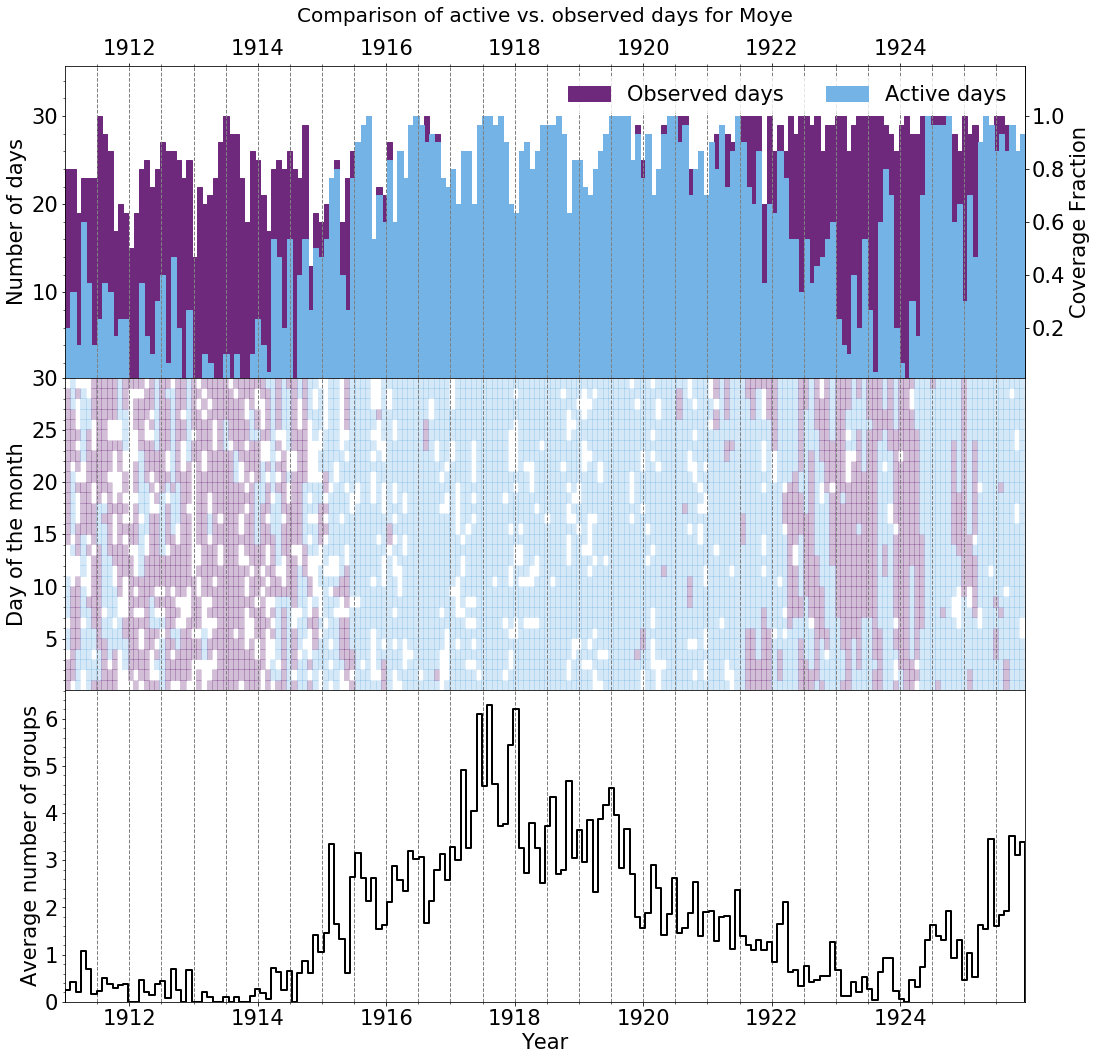

In [18]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltx = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltx = np.append(pltx,np.max(fyr2Ob))
pltx = np.append(pltx,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAv = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAv = np.insert(pltyAv,0,0)
pltyAv = np.append(pltyAv,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )          #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units



## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltx, pltyOb, color = Clr[2])
ax1.fill(pltx, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Observed days','Active days'], loc = 'upper right', ncol = 2, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number 
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
#ax3.fill(pltx, pltyAv+pltySd, color = '0.8')
#ax3.fill(pltx, pltyAv-pltySd, color = 'w')
ax3.plot(pltx, pltyAv, color = Clr[0], linewidth = 2)

# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0);

**FIGURES:** Same as previous figures but limiting RGO to an interval of the same length at the given observer and imprinted with the observer's missing days.


## Calculating RGO ADF for different thresholds after imprinting the missing days of the given observer 


In [19]:
#Number of thresholds 
thN = 9
CgrpRGOT = np.repeat(np.matrix(CgrpRGO),thN+1, axis = 0)

# Looping through different thresholds and calculating active day fraction
EMD = []
for i in range(1,thN+1):
    
    TgrpsRGO = np.nansum( np.greater(RGO_Dat.values[:,3:RGO_Dat.values.shape[1]-2],i*10) ,axis = 1).astype(float)
    TgrpsRGO[np.isnan(RGO_Dat['AREA1'])] = np.nan
    
    #Reducing to period match
    TgrpsRGO = TgrpsRGO[Idx1[0]:Idx2[0]]

    # Selecting the maximum integer amount of "months" out of the original data
    TgrpsRGO = TgrpsRGO[0:np.int(TgrpsRGO.shape[0]/MoLngt)*MoLngt]
    # Reshaping
    TgrpsRGO = TgrpsRGO.reshape((-1,MoLngt))

    # Removing days using mask
    TgrpsRGO[np.isnan(grpsOb)] = np.nan
    
    # Number of days with groups
    CgrpRGOT[i,:] = np.sum(np.greater(TgrpsRGO,0),axis=1)
    
    #Calculating Earth Mover's Distance
    ADFRGO, bins = np.histogram(np.squeeze(np.asarray(CgrpRGOT[i,:]))/30, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
    EMD.append(emd(ADFRGO.astype(np.float64),ADFObs.astype(np.float64),Dis.astype(np.float64)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


In [20]:
plt.rc('font', **font)

# Distribution Plots for RGO
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 200 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


for i in range(0, 3):
    for j in range(0,3):
        n = (3*(2-j)+i)

        # Top Distribution
        ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) , ppadv + j*(pxy/fszv+ppadv2) + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
        ax1.hist(np.squeeze(np.asarray(CgrpRGOT[n,:]))/30, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color='0.5', alpha=.6, density = True);
        ax1.plot(xAD, yAD, color=Clr[4], linewidth=3)

        # Axes properties
        ax1.set_xlim(left = -0.05, right = 1.05);
        ax1.set_axis_off()


        # Right Distribution
        ax2 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) + pxx/fszh*frc, ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc*(1-frc), pxy/fszv*frc])
        ax2.hist(CobsRGO/30, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt,  color='0.5', alpha=.6, orientation = 'horizontal', density = True);
        (xOD, yOD) = histOutline(obsOb/30, bins = (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        ax2.plot(yOD, xOD, color=Clr[2], linewidth=3)

        # Axes properties
        ax2.set_ylim(bottom = -0.05, top = 1.05);
        ax2.set_axis_off()

        # Scatter Plot
        ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
        ax1.scatter(np.squeeze(np.asarray(CgrpRGOT[n,:]))/30, CobsRGO/30, color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)

        # Axes properties
        ax1.set_ylabel('Observation day fraction')
        ax1.text(1.04, 0.5,'ODF', horizontalalignment='center', transform = ax1.transAxes, 
                 rotation = 'vertical', verticalalignment = 'center')
        ax1.set_xlabel('Active day fraction')
        ax1.text(0.5, 1.01,'ADF', horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.95, 0.05,  'Th: ' + str(n*10) + ' uHem  EMD: ' + str(np.round_(EMD[n], decimals = 2)), horizontalalignment='right', transform = ax1.transAxes)
        ax1.set_xlim(left = -0.05, right = 1.05)
        ax1.set_ylim(bottom = -0.05, top = 1.05);
        
        if EMD[n]==np.min(EMD):
            ax1.spines['bottom'].set_color('r')
            ax1.spines['top'].set_color('r') 
            ax1.spines['right'].set_color('r')
            ax1.spines['left'].set_color('r')




RuntimeError: Locator attempting to generate 42372 ticks from -96.35000000000001 to 2022.1999999998795: exceeds Locator.MAXTICKS

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000022D7C209C80> (for post_execute):


RuntimeError: Locator attempting to generate 42372 ticks from -96.35000000000001 to 2022.1999999998795: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 42372 ticks from -96.35000000000001 to 2022.1999999998795: exceeds Locator.MAXTICKS

<Figure size 5000x5000 with 3 Axes>

**FIGURE:** Each panel shows the scatter plot connecting the active day and observed day fraction, as well as the marginal distributions for each of the quantities. Gray shaded areas correspond to the distributions arising from RGO after uniform removal of days. Colored lines indicate the distributions for the given observer. Each panel denotes the threshold used to obtain the distributions, as well as the Earth Mover's distance (EMD). The panel outlined in red has the smallest EMD between RGO and the observer.  **Note how, by enforcing identical observed day fractions, ADFs are made comparable.**